### Import Libraries

In [57]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier 

DATA DICTIONARY :
* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts.illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### Read Dataset:

In [2]:
df = pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


###### In the Dataset there is 6362620 Rows which is too much complex for doing analysis
###### that why we are doing the Sampling in the original dataframe

In [3]:
sampled_df = df.sample(frac=0.1, random_state=42,ignore_index=True)

In [4]:
sampled_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
1,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
2,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
3,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
4,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0


In [5]:
# shape of Sample DataFrame:
sampled_df.shape

(636262, 11)

In [6]:
# See Datatypes of Features Using Info Function:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            636262 non-null  int64  
 1   type            636262 non-null  object 
 2   amount          636262 non-null  float64
 3   nameOrig        636262 non-null  object 
 4   oldbalanceOrg   636262 non-null  float64
 5   newbalanceOrig  636262 non-null  float64
 6   nameDest        636262 non-null  object 
 7   oldbalanceDest  636262 non-null  float64
 8   newbalanceDest  636262 non-null  float64
 9   isFraud         636262 non-null  int64  
 10  isFlaggedFraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


In [7]:
# No of Rows:
print("No of Rows:",sampled_df.shape[0])

No of Rows: 636262


In [8]:
# No of Columns:
print("No of Columns:",sampled_df.shape[1])

No of Columns: 11


In [9]:
# Basic statistics
print(sampled_df.describe())

                step        amount  oldbalanceOrg  newbalanceOrig  \
count  636262.000000  6.362620e+05   6.362620e+05    6.362620e+05   
mean      243.527333  1.810421e+05   8.285452e+05    8.499065e+05   
std       142.493187  6.136867e+05   2.877271e+06    2.913449e+06   
min         1.000000  0.000000e+00   0.000000e+00    0.000000e+00   
25%       156.000000  1.336292e+04   0.000000e+00    0.000000e+00   
50%       239.000000  7.494935e+04   1.411181e+04    0.000000e+00   
75%       335.000000  2.094772e+05   1.069565e+05    1.436672e+05   
max       742.000000  6.933732e+07   3.791982e+07    3.795009e+07   

       oldbalanceDest  newbalanceDest        isFraud  isFlaggedFraud  
count    6.362620e+05    6.362620e+05  636262.000000   636262.000000  
mean     1.106790e+06    1.232760e+06       0.001284        0.000002  
std      3.396119e+06    3.685490e+06       0.035811        0.001254  
min      0.000000e+00    0.000000e+00       0.000000        0.000000  
25%      0.000000e+00  

In [10]:
#Checking the balance of target variable
sampled_df.isFraud.value_counts()

isFraud
0    635445
1       817
Name: count, dtype: int64

In [11]:
# We will analyse the Numerical Column using select dtypes:
num_cols = sampled_df.select_dtypes(include=np.number).columns
num_cols

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [12]:
cat_cols = sampled_df.select_dtypes(include=object).columns
cat_cols

Index(['type', 'nameOrig', 'nameDest'], dtype='object')

# Visualization

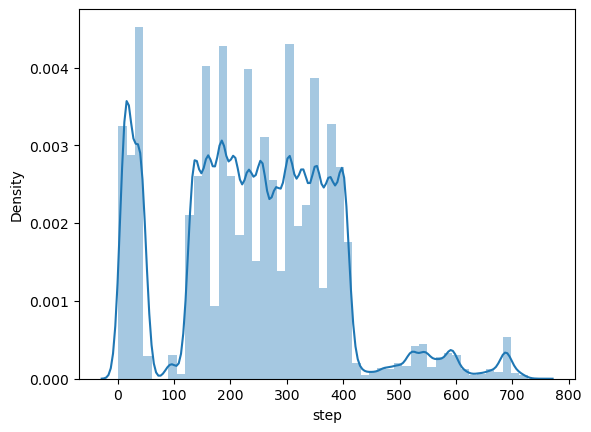

In [13]:
# Make a distplot of Step Variable .
sns.distplot(sampled_df["step"])
plt.show()

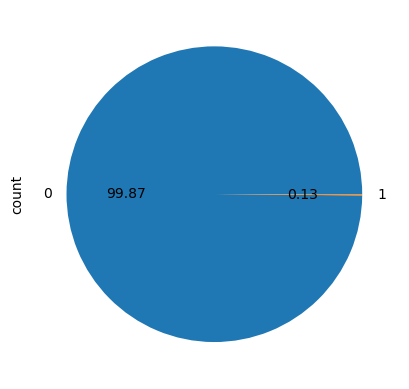

In [14]:
# Pie Plot For isfraud (Target Variable)
sampled_df["isFraud"].value_counts().plot(kind="pie",autopct="%.2f");

* In this Pie Chart 99.87 % value belongs to 0 
* and 0.13 % belongs to 1 .

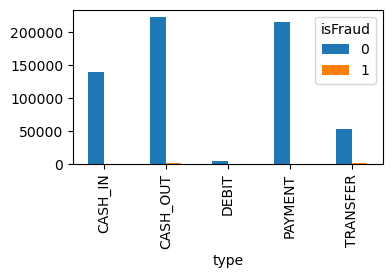

In [15]:
# Make bar plot for Type of Transaction by Target Variable.
gender=pd.crosstab(sampled_df["type"],sampled_df["isFraud"])
gender.plot(kind='bar',figsize=(4,2));

Inferences for bar Plot:
* Not isFraud is maximum by Cash out Type of Transaction

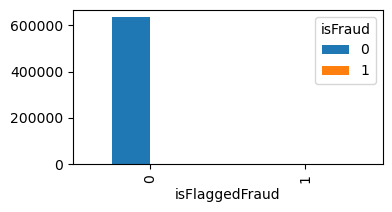

In [16]:
# Make bar plot for Type of Transaction by Target Variable.
gender=pd.crosstab(sampled_df["isFlaggedFraud"],sampled_df["isFraud"])
gender.plot(kind='bar',figsize=(4,2));

Inferences of bar plot :
* The bar plot shows that most transactions are not flagged as fraudulent, but many flagged transactions are actually not fraudulent. This indicates a high false positive rate in the fraud detection model.

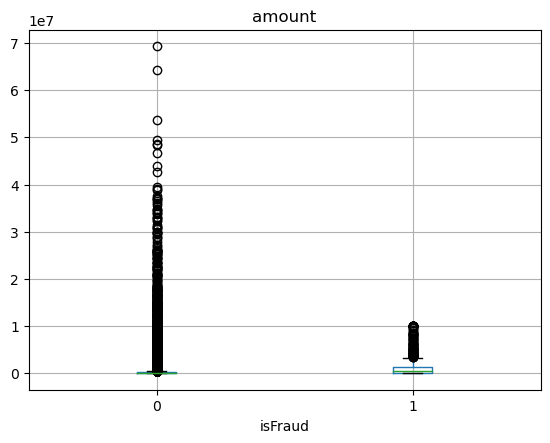

In [17]:
#Visualizing the amount considering whether transaction isfraud or not
sampled_df.boxplot(column='amount',by='isFraud')
plt.suptitle("")
plt.show()

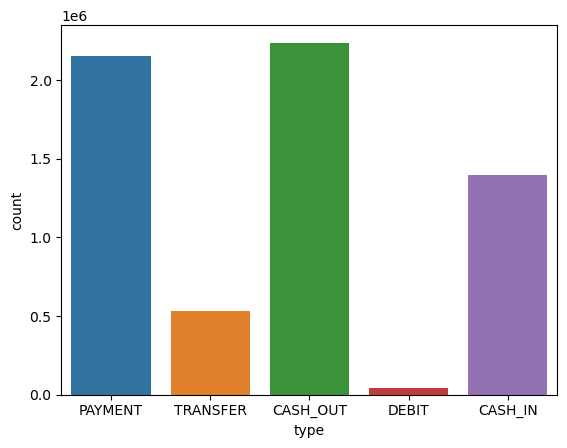

In [18]:
# CountPlot for Categorical Variable:
sns.countplot(data = sampled_df,x= df["type"])
plt.show()

Inferences for countplot for Type of Transaction:
* Cash out is Maximum in Type of Transaction
* Debit is minimum in Type of Transaction

## MISSING VALUES TREATMENT:

In [19]:
sampled_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

###### There is No Missing Values in this DataSet.

## OUTLIERS TREATMENT :

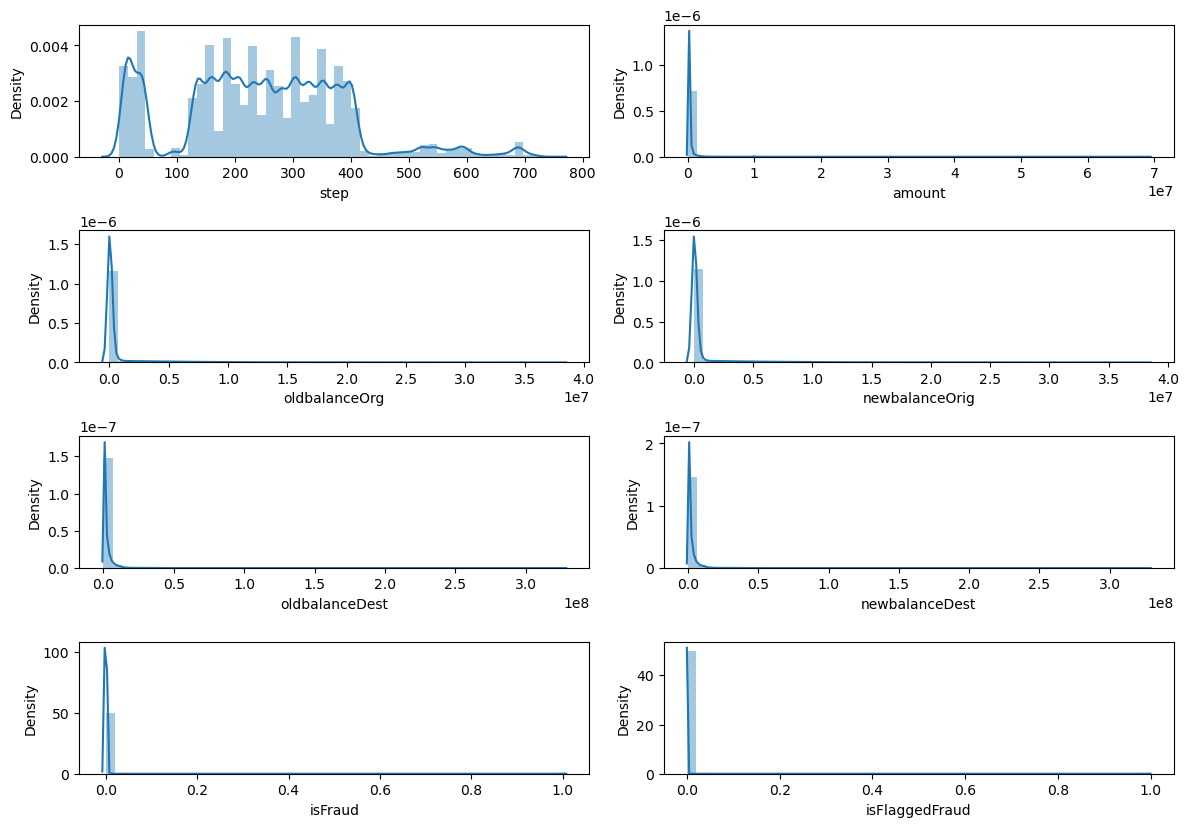

In [20]:
# Univariate Analysis For Numerical Features:
plt.figure(figsize=(12,10))
t = 1
for i in num_cols:
    plt.subplot(5,2,t)
    sns.distplot(sampled_df[i])
    
    t+=1
plt.tight_layout()
plt.show()

Inferences of distplot :
* The density plots show that most transactions are small, frequent, and involve accounts with lower balances. Fraudulent activity is common in the dataset.

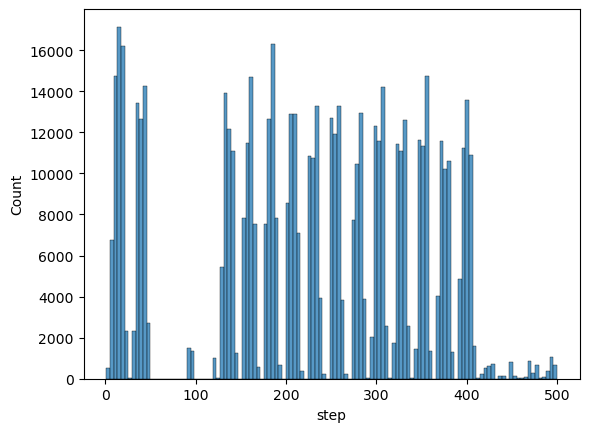

In [21]:
# 
sampled_df.drop(sampled_df['step'][sampled_df['step']>500].index, inplace=True)
sns.histplot(sampled_df['step'])
plt.show()

Inferences of Histplot :
* The histogram shows a high frequency of transactions around steps 100, 200, and 300, with a decreasing frequency towards higher steps. This suggests a cyclical pattern or grouping of transactions.

## Treating object data types for model building

In [22]:
#Chekcing the remaining columns to treat the object data types
sampled_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [23]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 606003 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            606003 non-null  int64  
 1   type            606003 non-null  object 
 2   amount          606003 non-null  float64
 3   nameOrig        606003 non-null  object 
 4   oldbalanceOrg   606003 non-null  float64
 5   newbalanceOrig  606003 non-null  float64
 6   nameDest        606003 non-null  object 
 7   oldbalanceDest  606003 non-null  float64
 8   newbalanceDest  606003 non-null  float64
 9   isFraud         606003 non-null  int64  
 10  isFlaggedFraud  606003 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 55.5+ MB


In [24]:
# Mapping the object columns to convert it into (0 and 1) form and then change the data type to int
sampled_df['type']=sampled_df['type'].map({'CASH_OUT':0, 'PAYMENT':1,'CASH_IN':2,'TRANSFER':3,'DEBIT':4})

In [25]:
# Drop 2 column by name :
sampled_df = sampled_df.drop('nameOrig', axis=1)
sampled_df = sampled_df.drop('nameDest', axis=1)

In [26]:
sampled_df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,278,2,330218.42,20866.00,351084.42,452419.57,122201.15,0,0
1,15,1,11647.08,30370.00,18722.92,0.00,0.00,0,0
2,10,2,152264.21,106589.00,258853.21,201303.01,49038.80,0,0
3,403,3,1551760.63,0.00,0.00,3198359.45,4750120.08,0,0
4,206,2,78172.30,2921331.58,2999503.88,415821.90,337649.60,0,0


In [27]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 606003 entries, 0 to 636261
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            606003 non-null  int64  
 1   type            606003 non-null  int64  
 2   amount          606003 non-null  float64
 3   oldbalanceOrg   606003 non-null  float64
 4   newbalanceOrig  606003 non-null  float64
 5   oldbalanceDest  606003 non-null  float64
 6   newbalanceDest  606003 non-null  float64
 7   isFraud         606003 non-null  int64  
 8   isFlaggedFraud  606003 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 46.2 MB


### Checking for Correlation:

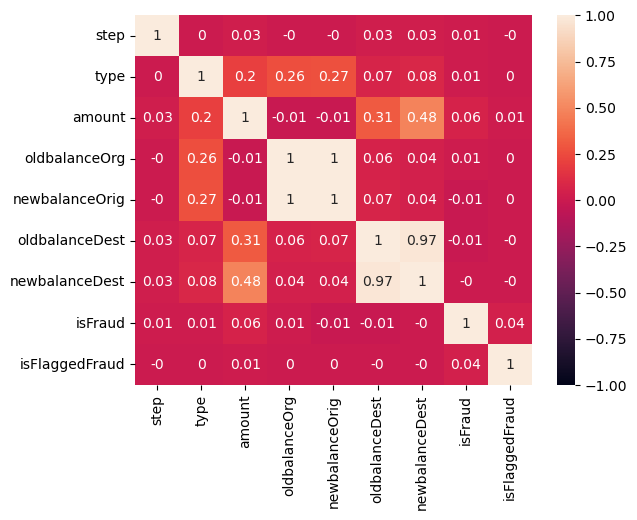

In [42]:
# Make Heat Map For Check Correlation :
sns.heatmap(np.round(sampled_df.corr(),2),annot=True,vmin=-1,vmax=1);

Inferences of Heat Map :
* High Correlations: The balance features (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest) are highly correlated with each other, as expected.

* Moderate Correlations: There are moderate correlations between amount and the balance features, indicating that larger transactions tend to involve higher account balances.

* Low Correlations: The features related to fraud (isFraud, isFlaggedFraud) have low correlations with most other features, suggesting that they may be influenced by factors not captured in the other variables.

### Check VIF(Variance Inflation Factor):

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
X = sampled_df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

         Features         VIF
0          amount    4.021676
1   oldbalanceOrg  577.615758
2  newbalanceOrig  579.571594
3  oldbalanceDest   65.821061
4  newbalanceDest   77.977735


## Split the Data in Train and Test Again...

In [29]:
newtrain = sampled_df.loc[0:sampled_df.shape[0]-1, ]
newtest = sampled_df.loc[sampled_df.shape[0]:, ]

In [30]:
newtrain.shape, newtest.shape, sampled_df.shape,df.shape

((577173, 9), (28830, 9), (606003, 9), (6362620, 11))

#### Dropping redundant columns

In [31]:
#Using get dummies for the remaining object columns for which mapping or encoder cant be used 
newtrain=pd.get_dummies(newtrain)
newtrain.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,278,2,330218.42,20866.00,351084.42,452419.57,122201.15,0,0
1,15,1,11647.08,30370.00,18722.92,0.00,0.00,0,0
2,10,2,152264.21,106589.00,258853.21,201303.01,49038.80,0,0
3,403,3,1551760.63,0.00,0.00,3198359.45,4750120.08,0,0
4,206,2,78172.30,2921331.58,2999503.88,415821.90,337649.60,0,0


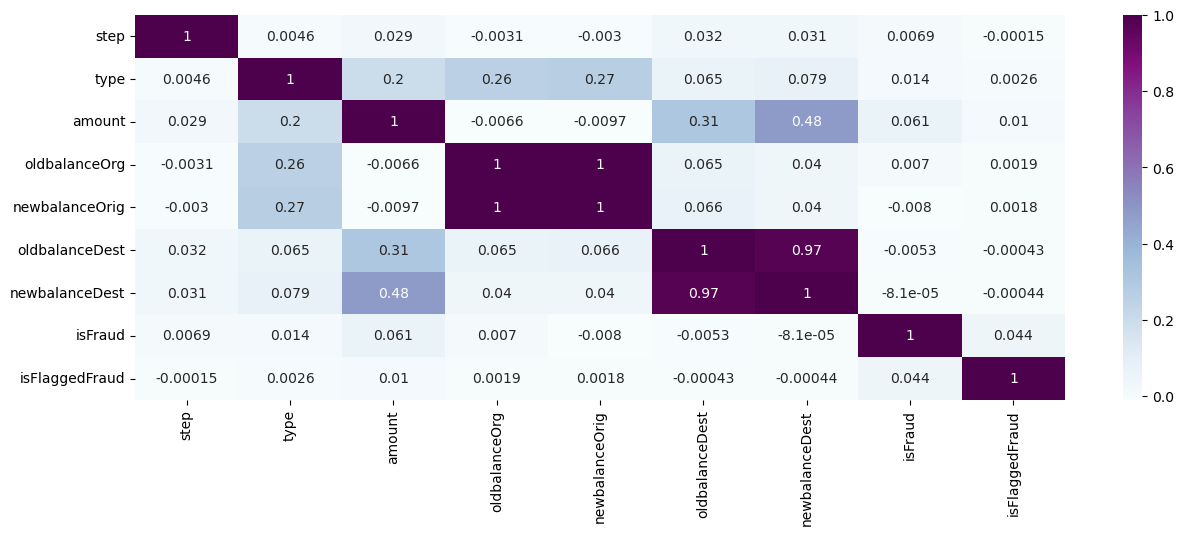

In [32]:
#Checking for correlation again now that we have treated the object columns
plt.figure(figsize=(15,5))
sns.heatmap(newtrain.corr(),cmap='BuPu',annot=True)
plt.show()

In [33]:
newtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 577173 entries, 0 to 606002
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            577173 non-null  int64  
 1   type            577173 non-null  int64  
 2   amount          577173 non-null  float64
 3   oldbalanceOrg   577173 non-null  float64
 4   newbalanceOrig  577173 non-null  float64
 5   oldbalanceDest  577173 non-null  float64
 6   newbalanceDest  577173 non-null  float64
 7   isFraud         577173 non-null  int64  
 8   isFlaggedFraud  577173 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 44.0 MB


* Finally all the object columns are treated and there are no null values in our data so we can start working on model building

## Model Building

In [34]:
# Encode categorical 'type' variable
le = LabelEncoder()
sampled_df['type'] = le.fit_transform(sampled_df['type'])

# Select features and target
X = sampled_df[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = sampled_df['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [35]:
# You can try other models like XGBoost or Logistic Regression
from xgboost import XGBClassifier

# XGBoost model
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_scaled, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test_scaled)

# Evaluation for XGBoost
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost ROC AUC Score: ", roc_auc_score(y_test, y_pred_xgb))


XGBoost Confusion Matrix:
 [[181627      8]
 [    40    126]]

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    181635
           1       0.94      0.76      0.84       166

    accuracy                           1.00    181801
   macro avg       0.97      0.88      0.92    181801
weighted avg       1.00      1.00      1.00    181801

XGBoost ROC AUC Score:  0.879496050101803


In [40]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluation
    print(f"=== {model_name} ===")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy Score :",accuracy_score(y_test,y_pred))
    print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))
    print("="*30)

=== Logistic Regression ===
Confusion Matrix:
 [[181632      3]
 [   120     46]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    181635
           1       0.94      0.28      0.43       166

    accuracy                           1.00    181801
   macro avg       0.97      0.64      0.71    181801
weighted avg       1.00      1.00      1.00    181801

Accuracy Score : 0.9993234360647081
ROC AUC Score:  0.6385459585472122
=== Random Forest ===
Confusion Matrix:
 [[181629      6]
 [    44    122]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    181635
           1       0.95      0.73      0.83       166

    accuracy                           1.00    181801
   macro avg       0.98      0.87      0.91    181801
weighted avg       1.00      1.00      1.00    181801

Accuracy Score : 0.9997249740100439
ROC AUC Score:  0.8674533628775

## Inferences of Model Building:

Logistic Regression:

* High accuracy but poor recall (0.28), meaning it misses many fraud cases.
* Suitable if interpretability is the primary concern but not ideal for catching fraud.

Random Forest:

* High precision (0.95) and recall (0.73), making it well-suited for detecting fraud while minimizing false positives.
* Strong performance overall (ROC AUC: 0.867).

XGBoost:

* Best balance between precision (0.94) and recall (0.76).
* Best overall performance (ROC AUC: 0.879), making it the top choice for detecting fraud.

Gradient Boosting:

* Lower precision, recall, and AUC compared to Random Forest and XGBoost.
* Not as effective for this dataset.

Conclusion:
* XGBoost and Random Forest outperform the other models, with XGBoost slightly ahead in terms of ROC AUC and recall.
* XGBoost is the best-performing model for fraud detection, balancing precision and recall well, making it an ideal choice for   this use case.

## THANK YOU ...